# Logistic Regression
Logistic Regression is a popular and powerful machine learning algorithm that learns the relationship between a target binary variable and one or more input variables. Despite its name, Logistic Regression is in modern terminology a form of classification algorithm rather than regression algorithm. Its name is based on the fact that the core of the algorithm is founded on fundamentally the same mechanisms as Linear Regression.

In Logistic Regression our target variable $Y$ is assumed to be a binary variable that represents some class. For example, the class could be **Sex** with two constituent categories **Male** and **Female**. However we model the problem with a binary target variable. By convention our target $Y \in \{1,0\}$ where:
 * 0 represents one class
 * 1 represents the other class

For a model with 1 predictor feature and our target variable we can assume a training set of $m$ cases:

\begin{equation}
\{ (X^{1},Y^{1}),(X^{2},Y^{2}),(X^{3},Y^{3})\dots(X^{M},Y^{M})               \}
\end{equation}

where, as before, the superscript notation is used to denote a specific training instance.

To demonstrate the form and use of the Logistic Function in the case of a single predictor feature, let us introduce an example based around the relationship between Type II Diabetes and Average Daily Sugar Consumption.

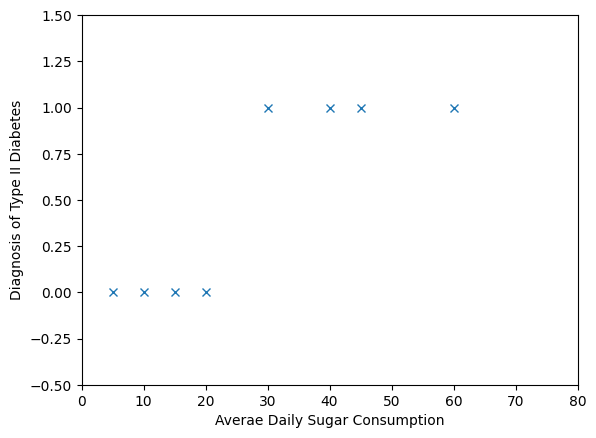

In [29]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

# Target Variable - diagnosed onset of Type II diabetes
Y = np.array([0,0,0,0,1,1,1,1])
# Input Feature - Average daily consumption of added sugars in grammes
X = np.array([5,10,15,20,30,40,45,60])

plt.plot(X,Y, "x")
plt.xlabel('Averae Daily Sugar Consumption')
plt.ylabel('Diagnosis of Type II Diabetes')
plt.ylim([-0.5,1.5])
plt.xlim([0,80])
plt.show()

As can be seen there is a clear relationship between the amount of additional sugar consumed daily and the onset of diabetes (it should be noted that this is idealised data and not taken from a specific study). The question is how do we best model this data.

## Modelling Binary Targets with Linear Regression
Before introducing Logistic Regression we first investigate the application of Linear Regression to our example.

We first import two important function definitions that we previously established in the Linear Regression notes. One notable difference is that we separate out the calculation of the hypothesis for linear regression into a separate function. This just makes it easier for us to swap from Linear Regression to Logistic Regression later.

In [30]:
# Standardization over 2D arrays
def standardize(x):
    col_means = np.mean(x,axis=0)
    col_std = np.std(x,axis=0)
    return (x - col_means) / col_std , col_means, col_std

# Linear Regression Function definition
def hLinear(theta_in,X_in):
    return np.matmul(theta_in,X_in)

# Cost function for Linear regression
def cost_linear(theta,xi,yi):
    # note - this function calculate the cost for all variations of theta. A vector is returned.
    h = np.matmul(theta,xi)
    rv = ((h - yi)**2) / 2
    return rv

# The outer cost function 'J' calculator. This iterates over our training cases.
def J(theta,x,y,f):
    s = 0
    m = len(x)
    for i in range(0,m):
        v = f(theta,x[i],y[i])
        s+= v
    return s / m

# implementation of the gradient descent algorithm
def gd(theta_in,min_delta_in,a_in,X_in,Y_in,h,maxiterations=-1,cost=cost_linear):
    m = len(Y_in) # number of training examples
    _ , n = np.shape(X_in) # number of features

    # define a list used to store the costs - these do not have to be calculated but are useful for debugging
    c = []

    # Create a theta variable which we will use to keep track of the current value of theta
    theta = theta_in

    # Create a list which we will use for storing theta results during optimization
    thetas = np.array(theta_in,ndmin=2)

    # Create a counter which is used for limiting the number of iterations used if maxiterations has been defined
    k = 0

    # Begin main search loop
    while maxiterations == -1 or k < maxiterations:
        k+=1
        # log the cost - useful for visualisation and later analysis
        c.append(J(theta_in,X_in,Y_in,cost))

        # save a copy of the parameters -- this is the set we will read from
        temp = np.copy(theta)
        # iterate over all features -- remember though that we apply changes in parallel
        for j in range(0,n):
            # making calculations for jth parameter
            s = 0
            # calculate our gradient update over all training cases
            for i in range(0,m):
                s+=  (h(temp.T,np.ravel(X_in[i,:])) - Y_in[i])  * X_in[i,j]
            theta[j] = temp[j] - a_in * (1/m) * s

        # log the changed parameters
        thetas = np.vstack((thetas,theta))

        # not lets check to see if we are still making progress -- i.e., that our cost is reducing
        # we check to make sure that at least one of our parameters is changing by a minimum threshold
        progressing = False
        for j in range(0,n):
            if(abs(temp[j] - theta[j]) > min_delta_in):
                progressing = progressing | True
        if not progressing: break

    # if we have completed a maximum number of iterations -- or if we are no longer improving -- return
    return thetas, c

We begin by first normalizing our data with z-score standardization in the usual way.

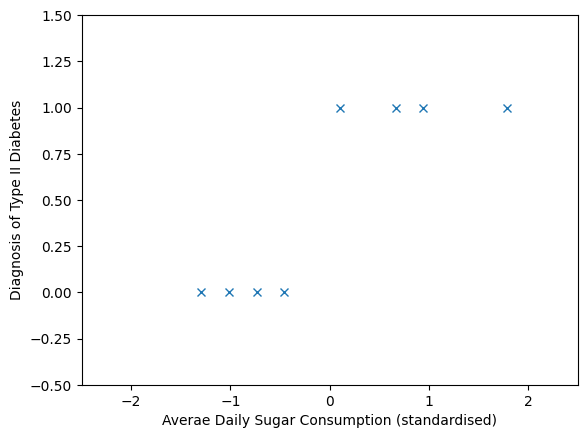

In [31]:
X, means, stds = standardize(X)

plt.plot(X,Y, "x")
plt.xlabel('Averae Daily Sugar Consumption (standardised)')
plt.ylabel('Diagnosis of Type II Diabetes')
plt.ylim([-0.5,1.5])
plt.xlim([-2.5,2.5])
plt.show()

We can then directly apply Linear Regression to our training data set.   

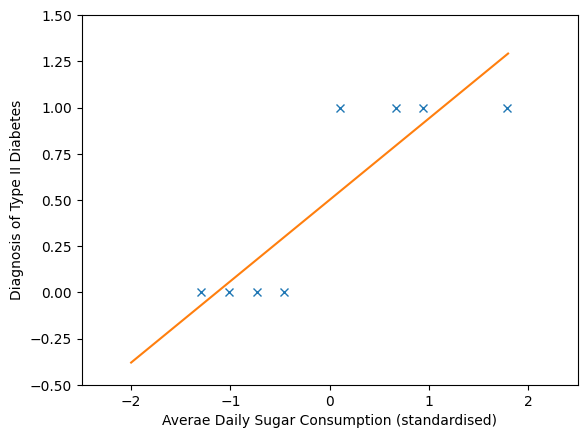

In [32]:
# define initial values for theta
theta = np.ones(2)
theta[0] = np.mean(Y) # remember - we directly calculate t0

# set min_delta and a
md = 0.01
a = 0.75

# define the new matrix X based around our standardized vector for X previously obtained
# remember that x_0 are fake features that we always set to 0 as it makes the calculations easier
x_0 = np.array([1]*len(X))
X = np.vstack((x_0,X)).T

# Run gradient descent
thetas,costs = gd(theta,md,a,X,Y,hLinear)

# plot a number of new points based on the returned function parameters
x1 = np.arange(-2,2,0.2)
x0 = np.array([1]*len(x1))
x = np.vstack((x0,x1)).T
y = np.matmul(thetas[-1,:],x.T)

plt.plot(X[:,1],Y, "x")
plt.xlabel('Averae Daily Sugar Consumption (standardised)')
plt.ylabel('Diagnosis of Type II Diabetes')
plt.ylim([-0.5,1.5])
plt.xlim([-2.5,2.5])
plt.plot(x[:,1],y)
plt.show()

Looking at the output of our Linear Regression function we are reminded that the range of the function is $\in R$ and as such  is not a good fit for our classification task. However we can fix this easily by adopting a thresholding policy such that if:
\begin{equation}
  h_{\theta}(x) \geq 0.5 \; then \; y = 1
\end{equation}
\begin{equation}
  h_{\theta}(x) \leq 0.5 \; then \; y = 0
\end{equation}

which can be coded up as follows:

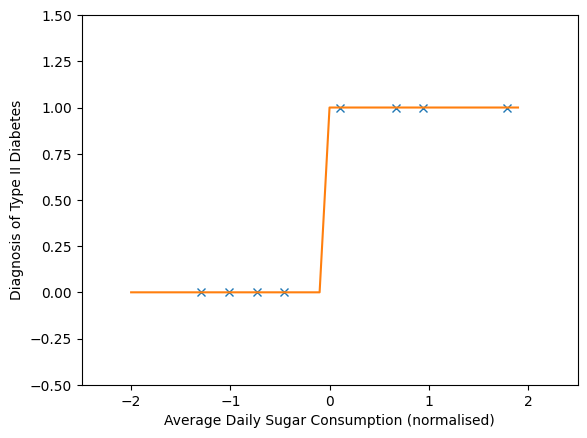

In [33]:
def threshold(x):
    if x >= 0.5: return 1
    else: return 0
threshold = np.vectorize(threshold)

# plot a number of new points based on the returned function parameters
x1 = np.arange(-2,2,0.1)
x0 = np.array([1]*len(x1))
x = np.vstack((x0,x1)).T
y = np.matmul(thetas[-1,:],x.T)
y = threshold(y)

plt.plot(X[:,1],Y, "x")
plt.xlabel('Average Daily Sugar Consumption (normalised)')
plt.ylabel('Diagnosis of Type II Diabetes')
plt.ylim([-0.5,1.5])
plt.xlim([-2.5,2.5])
plt.plot(x[:,1],y)
plt.show()

#### Problems with Linear Regression

Looking at the output of our function it seems to have given us a relatively good approximation of our data. All data points seem aligned with the function output. However this simple thresholded function has two major limitations:
 * First, our thresholded function is not a smooth function. This is important when it comes to training algorithms which often depend on having a continuous function so that we can calculate the derivative.
 * Second, the function performs poorly when the distributions of the data are not so ideal

To understand this second point lets extend our diabetes example with a number of other data points.

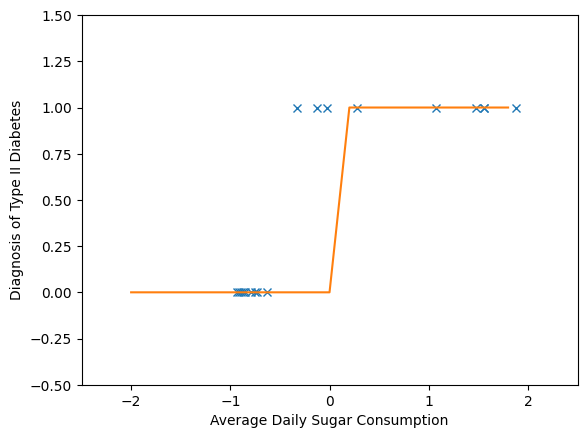

In [34]:
# define data and standardize
Y = np.array([0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1])
X = np.array([0,1,2,3,4,7,9,10,15,30,40,45,60,100,120,124,124,140])
X, means, stds = standardize(X)

# define initial values for theta
theta = np.ones(2)
theta[0] = np.mean(Y) # remember - we directly calculate t0

# set min_delta and a
md = 0.01
a = 0.75

# define the new matrix X based around our standardized vector for X previously obtained
x_0 = np.array([1]*len(X))
X = np.vstack((x_0,X)).T

# Run gradient descent
thetas,costs = gd(theta,md,a,X,Y,hLinear)

# plot a number of new points based on the returned function parameters
x1 = np.arange(-2,2,0.2)
x0 = np.array([1]*len(x1))
x = np.vstack((x0,x1)).T
y = np.matmul(thetas[-1,:],x.T)
y = threshold(y)

plt.plot(X[:,1],Y, "x")
plt.xlabel('Average Daily Sugar Consumption')
plt.ylabel('Diagnosis of Type II Diabetes')
plt.ylim([-0.5,1.5])
plt.xlim([-2.5,2.5])
plt.plot(x[:,1],y)
plt.show()

In this case we can see that a number of instances of label 1 are now incorrectly going to be labeled as 0. This is in spite of the fact that there is still a very clear boundary between cases of 0 and cases of 1.

In summary we can use Linear Regression to solve problems like this, but it is not a particularly good solution. We will see that Logistic Regression gives us a solution that is specifically tailored to the binary label problem.

## The Logistic Function
Logistic Regression is based around the idea that a particular type of function, the Logistic Function, provides a better fit to our data than a straightforward linear function or even a thresholded linear function. The logistic function is of the form:

\begin{equation}
 h_{\theta}(x) = \frac{1}{1+e^{-z}}
\end{equation}

where $z$ can be any real number but in our case is usually taken to be $\theta^{T}X$, i.e., the result of a linear function as we have used in Linear Regression. This value z is often called the logit.

We can gain an intuition about the structure of the Logistic Function by visualizing its components.

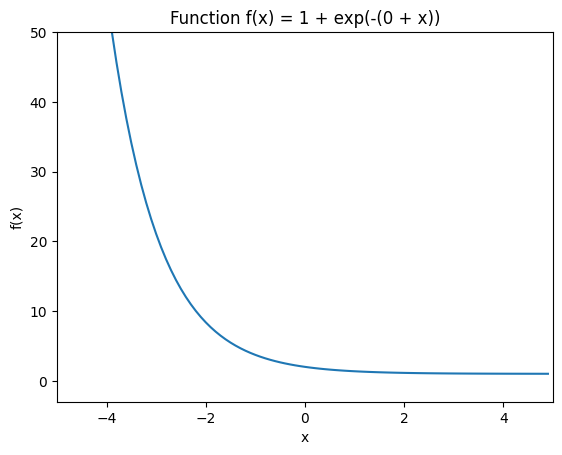

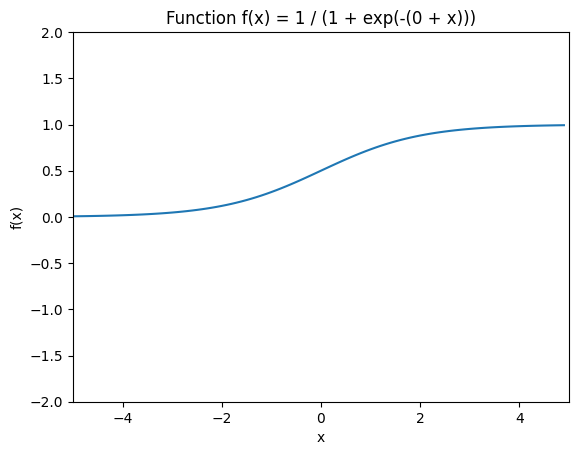

In [35]:
x1 = np.arange(-5,5,0.1)
x0 = np.array([1]*len(x1))
x = np.vstack((x0,x1))
z = np.matmul(np.array([0,1]),x)

plt.plot(x1,1+np.exp(-z))
plt.xlim([-5,5])
plt.ylim([-3,50])
plt.title('Function f(x) = 1 + exp(-(0 + x))')
plt.ylabel("f(x)")
plt.xlabel("x")
plt.show()
plt.plot(x1,1/(1 + np.exp(-z)))
plt.xlim([-5,5])
plt.ylim([-2,2])
plt.title('Function f(x) = 1 / (1 + exp(-(0 + x)))')
plt.ylabel("f(x)")
plt.xlabel("x")
plt.show()

We see that the function $f(x) = 1+e^{-x}$ is a vertically displaced inverse exponential function which has a limit of $1$ in the positive x direction and a limit of infinity in the negative x direction. Our Logistic Function is the reciprocal value of this function. Considering the limits just mentioned, the limits of the reciprocal are therefore $\frac{1}{\infty} = 0$ in the negative x direction and $\frac{1}{1} = 1$ in the positive x direction. This gives us a convenient s-shaped function that is bounded between 0 and 1.

Using the vector notation introduced for Linear Regression we can re-write the Logistic Function as follows:

\begin{equation}
 h_{\theta}(x) = g(\theta^{T}x)
\end{equation}

where

\begin{equation}
 g(z) = \frac{1}{1+e^{-z}}
\end{equation}

This is the general form of the Logistic Function that we will use throughout this section. We see that the parameter $z$ is taken to be the product of $\theta$ and $x$ as used in the linear regression equation. At this stage it is worth noting that this is a very important function in Deep Learning and is worth paying attention to.

The severity of the transition between 0 and 1 is controlled by the parameter $\theta_{1}$. We can illustrate this with a number of examples:

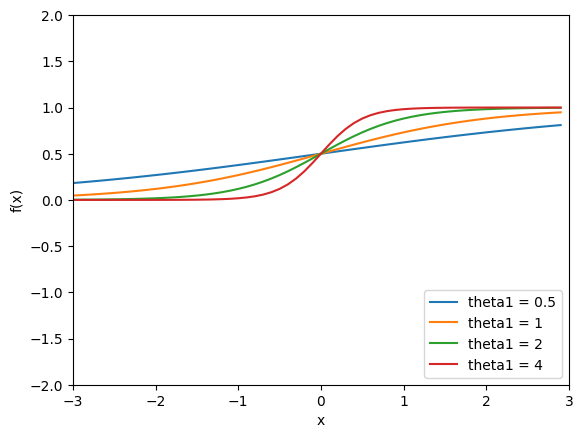

In [36]:
x1 = np.arange(-3,3,0.1)
x0 = np.array([1]*len(x1))
x = np.vstack((x0,x1))
z0 = np.matmul(np.array([0,0.5]),x)
z1 = np.matmul(np.array([0,1]),x)
z2 = np.matmul(np.array([0,2]),x)
z3 = np.matmul(np.array([0,4]),x)

plt.plot(x1,1/(1 + np.exp(-z0)))
plt.plot(x1,1/(1 + np.exp(-z1)))
plt.plot(x1,1/(1 + np.exp(-z2)))
plt.plot(x1,1/(1 + np.exp(-z3)))
plt.xlim([-3,3])
plt.ylim([-2,2])
plt.ylabel("f(x)")
plt.xlabel("x")
plt.legend(['theta1 = 0.5','theta1 = 1', 'theta1 = 2', 'theta1 = 4'], loc='lower right')
plt.show()

Similarly we can see that the logistic function is displaced along the x axis through the parameter $\theta_{0}$.

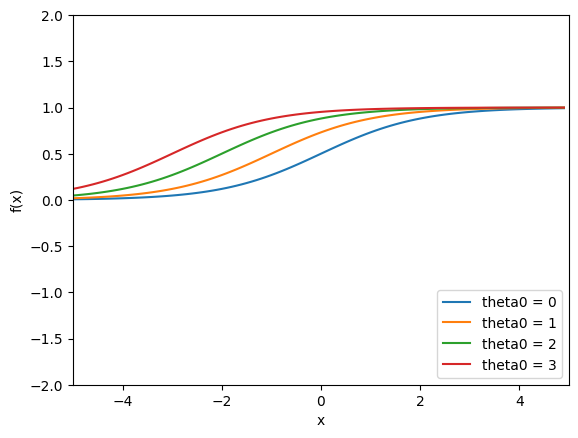

In [37]:
x1 = np.arange(-5,5,0.1)
x0 = np.array([1]*len(x1))
x = np.vstack((x0,x1))
z1 = np.matmul(np.array([0,1]),x)
z2 = np.matmul(np.array([1,1]),x)
z3 = np.matmul(np.array([2,1]),x)
z4 = np.matmul(np.array([3,1]),x)

plt.plot(x1,1/(1 + np.exp(-z1)))
plt.plot(x1,1/(1 + np.exp(-z2)))
plt.plot(x1,1/(1 + np.exp(-z3)))
plt.plot(x1,1/(1 + np.exp(-z4)))
plt.xlim([-5,5])
plt.ylim([-2,2])
plt.ylabel("f(x)")
plt.xlabel("x")
plt.legend(['theta0 = 0', 'theta0 = 1', 'theta0 = 2', 'theta0 = 3'], loc='lower right')
plt.show()

### Aside: Logistic Functions & Sigmoid Functions

The Logistic Function is one instance of the class of Sigmoid Functions which all broadly have an s-shape and are bounded between certain limits. Some other important examples of sigmoid functions include:

\begin{equation}
f(x) = tanh(x)
\end{equation}

\begin{equation}
f(x) = \frac{x}{1 + |x|}
\end{equation}

We illustrate these below alongside the logistic function. Note that not all logistic functions are naturally bounded between 0 and 1.  

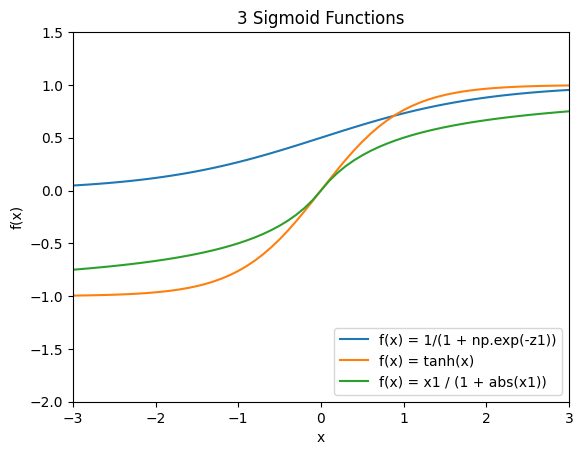

In [38]:
plt.plot(x1,1/(1 + np.exp(-z1)))
plt.plot(x1,np.tanh(x1))
plt.plot(x1,x1 / (1 + abs(x1)))

plt.xlim([-3,3])
plt.ylim([-2,1.5])
plt.ylabel("f(x)")
plt.xlabel("x")
plt.title("3 Sigmoid Functions")
plt.legend(['f(x) = 1/(1 + np.exp(-z1))', 'f(x) = tanh(x)', 'f(x) = x1 / (1 + abs(x1))'], loc='lower right')
plt.show()

### Interpreting the Logistic Function
As noted the Logistic Function gives an output in [0,1]. This helps us to give our logistic function based model $h_{\theta}$ a  probabilistic interpretation. Namely we interpret $h_{\theta}(x)$ as the estimated probability that $y=1$ given an input $x$. More formally

\begin{equation}
h_{\theta}(x) = P(Y=1 \;|\; x_{i},\theta)
\end{equation}

This gives us a good mechanism for balancing out the fact that we know $Y\in\{0,1\}$ while $h_{\theta}(x) \in [0,1]$.   From this we can also obtain:

\begin{equation}
P(Y=0 \;|\; x_{i},\theta) = 1 - h_{\theta}(x)
\end{equation}

We can also interpret our hypothesis function as defining a **Decision Boundary** between cases where we expect $Y=1$ and $Y=0$. In general we expect $Y=1$ where $h_{\theta}(x)>=0.5$ and $Y=0$ where $h_{\theta}(x)<0.5$.

### Applying Logistic Function to the Diabetes Dataset
Given our definition of the Logistic function, we can manually fit a logistic function to our Diabetes data from above.

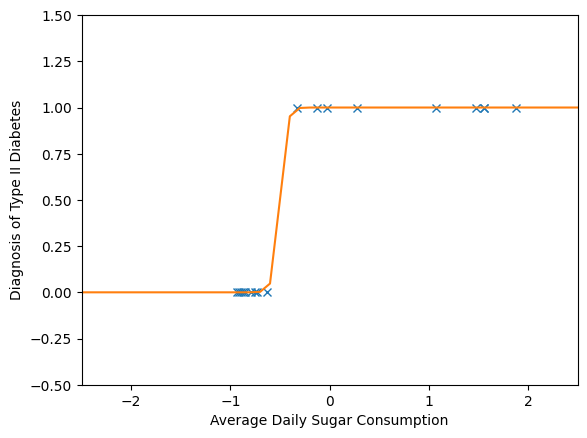

In [39]:
plt.plot(X[:,1],Y, "x")
plt.xlabel('Average Daily Sugar Consumption')
plt.ylabel('Diagnosis of Type II Diabetes')

x1 = np.arange(-2.5,3,0.1)
x0 = np.array([1]*len(x1))
x = np.vstack((x0,x1))
z1 = np.matmul(np.array([15,30]),x)

plt.plot(x1,1/(1 + np.exp(-z1)))
plt.ylim([-0.5,1.5])
plt.xlim([-2.5,2.5])
plt.show()

We can see that as hoped this provides a significantly better fit to our data than our original thresholded linear function. The step between g(z) = 0 and g(z) = 1 has now been displaced to better fit where this transition occurs in our data. The function itself is now also smooth. Of course, we have manually selected our parameters, now we need to consider how to achieve this automatically through optimization.

## Logistic Cost Function
Optimization of the Logistic Function requires that we find the set of parameters $\theta$ that produces a function that best matches our training data. We will see that we don't however use the Squared Error cost function for this, instead we will use a cost function specific to Logistic Regression.  

That said, before we introduce this new cost function, let us first consider the option of directly using the Squared Error cost function. The code below plots the sum of square error cost for a range of values for X and Y.  

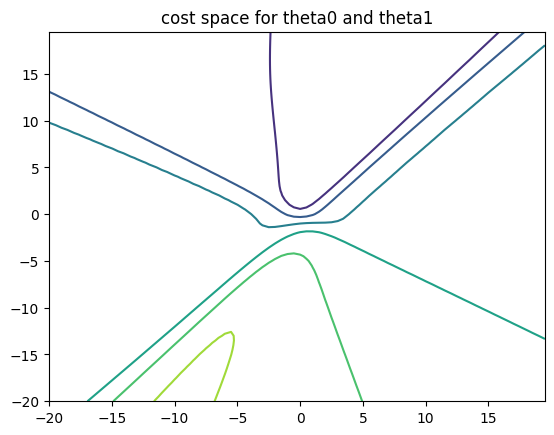

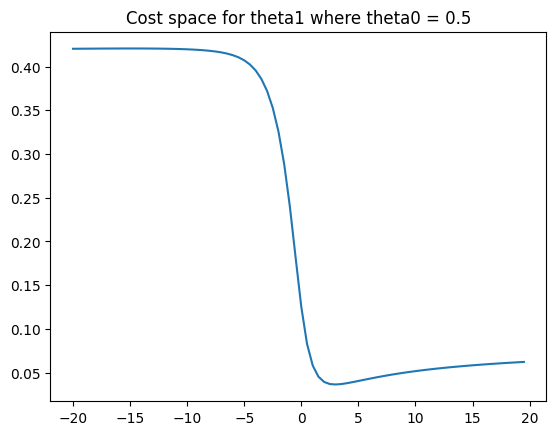

In [40]:
from matplotlib import cm

def cost(theta,xi,yi):
    # note - this function calculate the cost for all variations of theta. A vector is returned.
    z = np.matmul(theta,xi)
    h = 1 / (1 + np.exp(-z))
    rv = ((h - yi)**2) / 2
    return rv

def J(theta,x,y,f):
    s = 0
    m = len(x)
    for i in range(0,m):
        v = f(theta,x[i],y[i])
        s+= v
    return s / m

theta0_range = np.arange(-20,20,0.5)
theta1_range = np.arange(-20,20,0.5)

theta0s, theta1s = np.meshgrid(theta0_range, theta1_range)
mesh_rows, mesh_cols = theta0s.shape

theta0s_id = np.ravel(theta0s)
theta1s_id = np.ravel(theta1s)
theta = np.vstack((theta0s_id,theta1s_id)).T   # 10000 x 2 10000 different theta sets

costs = J(theta,X,Y,cost)

# reshape result to have the same organization as result of meshgrid \n",
costs = np.reshape(costs,(mesh_rows,mesh_cols))

plt.figure()
plt.contour(theta0s,theta1s,costs)
plt.title("cost space for theta0 and theta1")
plt.show()

theta1_range = np.arange(-20,20,0.5)
theta0_range = np.array([0.0]*len(theta1_range))
theta = np.vstack((theta0_range,theta1_range)).T   # 10000 x 2 10000 different theta sets
costs = J(theta,X,Y,cost)

plt.figure()
plt.plot(theta1_range,costs)
plt.title("Cost space for theta1 where theta0 = 0.5")
plt.show()

We can see that in this case the error space now looks a lot more complex than for linear regression. Our bowl-like convex function has been replaced with a non-convex function. While this may not strictly speaking be a problem for the current example the non-convex cost function can lead to non-optimal solutions in more complex examples.

### Cross Entropy Loss Function

For Logistic Regression we base our cost function on the following cost heuristic:

\begin{equation}
cost(h_{\theta}(x^{(i)}),y^{(i)}) = -y^{(i)} log(h_{\theta}(x^{(i)}))   - (1-y) log(1 - h_{\theta}(x^{(i)}))
\end{equation}

which is referred to as the Cross Entropy Cost Function. This function may look a bit intimidating at first, but it is actually very straightforward and almost as easy to interpret as the Sum of Squared Error Cost Function.

To begin with, there are two interesting notes about this cost function. First, the cost function is calculated differently depending on whether our target value is 0 or 1. In other words, the function has two distinct halves, and only one of these is in play depending on whether our label is 0 or 1.

Second, the cost function heavily penalizes cases where the hypothesis function gives the opposite of what is expected.

We can illustrate these two properties by plotting our cost function for the cases of Y=1 and Y=0.

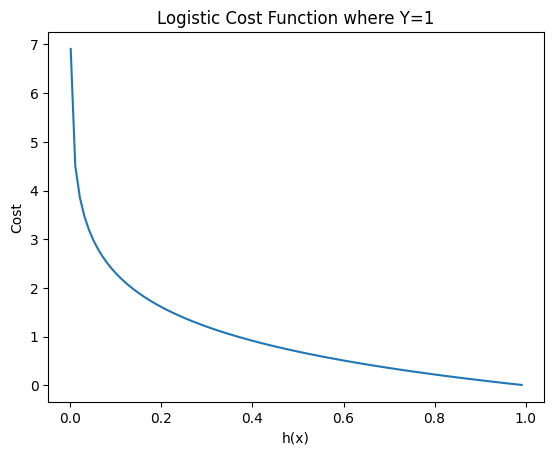

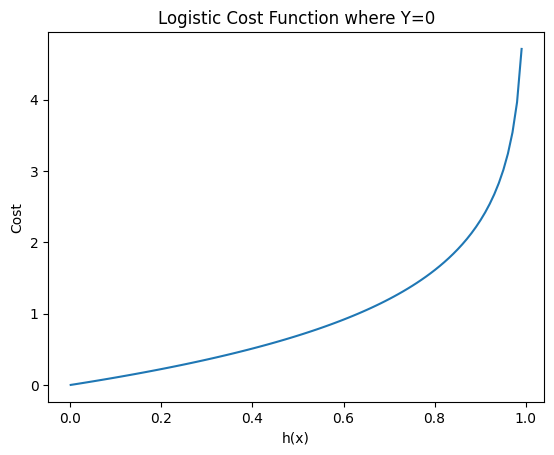

In [41]:
h = np.arange(0.001,0.999,0.01)
plt.figure()
plt.xlabel('h(x)')
plt.ylabel('Cost')
plt.plot(h,-np.log(h))
plt.title("Logistic Cost Function where Y=1")
plt.show()

plt.xlabel('h(x)')
plt.ylabel('Cost')
plt.plot(h,-np.log(1-h))
plt.title("Logistic Cost Function where Y=0")
plt.show()

An important technical point to note is that the cost function is dependent on calculating logs of the sigmoid function. This calculation is dependent on the fact that the sigmoid function should in the strict mathematical sense converge towards but never reach 0 and 1. If when y=1 h is exactly 0 then the log is undefined. Similarly when y=0 and z=1 the log is similarly not defined. This explains our reason for selecting bounds of 0.001 and 0.999 in our illustration of the logistic cost functions above.

While the sigmoid function should not produce either an output that is exactly equal to 0 or 1, rounding will in practice lead to this occurring. For this reason we implement the cost function with an if else construct to avoid calculating the log where a singularity would occur.

### Logistic Cost Function Formal Definition
We can take our cost heuristic defined above and build it in to a full formal cost definition for $J(\theta)$ as follows.

Looking again at a formal definition of cost for multivariate Linear Regression we have

\begin{equation}
J(\theta) = \frac{1}{2m}     \sum_{i=0}^{m}  (h_{\theta}(x^{(i)}) - y^{(i)})^{2}
\end{equation}

where
 * $\theta$ is the vector of parameters of our model
 * $m$ is the number of training examples
 * $y^{i}$ is the ith target value
 * $x^{i}$ is the ith feature, and
 * $h_{\theta}$ is our model / function of $x$ that we wish to evaluate.
 * 2, or rather $\frac{1}{2}$, is a constant we introduce to allow the calculation of the derivative of J to be more straightforward.

We can generalize this cost function $J(\theta)$ by moving our derivative constant inside the summation

\begin{equation}
J(\theta) = \frac{1}{m}     \sum_{i=0}^{m} \frac{1}{2} (h_{\theta}(x^{(i)}) - y^{(i)})^{2}
\end{equation}

And then separating out the summation argument into a separate function as follows:

\begin{equation}
J(\theta) = \frac{1}{m}     \sum_{i=0}^{m} cost_{linear}(h_{\theta}(x^{(i)}),y^{(i)})
\end{equation}

where

\begin{equation}
cost_{linear}(h_{\theta}(x^{(i)}),y^{(i)})  = \frac{1}{2} (h_{\theta}(x^{(i)}) - y^{(i)})^{2}
\end{equation}

Using the general template for $J(\theta)$ we can substitute our heuristic for Logistic Regression to obtain the following function:

 \begin{equation}
J(\theta) = \frac{1}{m} \sum_{i=1}^{m} cost_{logistic}(h_{\theta}(x^{(i)}),y^{(i)})
\end{equation}

where

\begin{equation}
cost_{logistic}(h_{\theta}(x^{(i)}),y^{(i)}) = -y^{(i)} log(h_{\theta}(x^{(i)}))   - (1-y^{(i)}) log(1 - h_{\theta}(x^{(i)}))
\end{equation}

Note that our general template for $J(\theta)$ simply states that we average over individual costs for each data point. Costs for individual data points are calculated very differently between our original Linear Regression cost function and our Logistic Regression Cost Function.

We can illustrate the properties of our Logistic Cost function directly with a number of examples with respect to our Diabetes data set.

In [42]:
def cost_logistic(theta,xi,yi):
    # note - this function calculate the cost for all variations of theta. A vector is returned.
    z = np.matmul(theta,xi)
    h = 1 / (1 + np.exp(-z))
    if yi == 1:
        return -np.log(h)
    elif yi == 0:
        return -np.log(1-h)
    else: raise ValueError('yi was neither 0 nor 1: ' + str(yi))

costs = J(np.array([15.0,30.0]),X,Y,cost_logistic)
print("Costs : " + str(costs))

# shift to the left - all y=0 cases should fail
costs = J(np.array([30.0,30.0]),X,Y,cost_logistic)
print("Costs : " + str(costs))

# shift to the right - some y=1 cases should fail
costs = J(np.array([0.0,30.0]),X,Y,cost_logistic)
print("Costs : " + str(costs))

# shift to the right - some y=1 cases should fail
costs = J(np.array([1.0,1.0]),X,Y,cost_logistic)
print("Costs : " + str(costs))

# shift to the right - some y=1 cases should fail
costs = J(np.array([0.0,0.0]),X,Y,cost_logistic)
print("Costs : " + str(costs))


Costs : 0.0015778308789776117
Costs : 2.7755862143275576
Costs : 0.8243068625612893
Costs : 0.4914370094254397
Costs : 0.6931471805599453


Similarly we can plot a contour map of the logistic regression cost function over a range of parameter values.

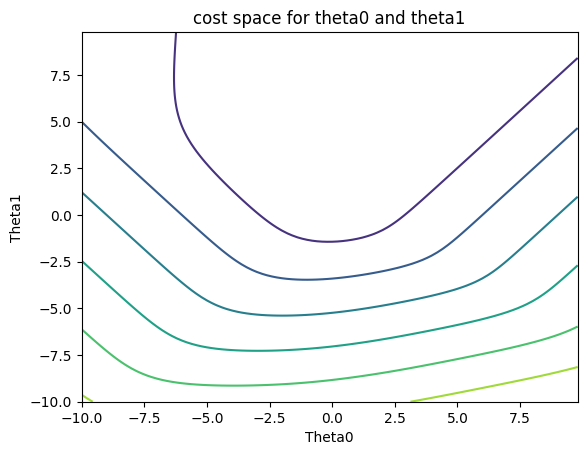

In [43]:
theta0_range = np.arange(-10,10,0.2)
theta1_range = np.arange(-10,10,0.2)

theta0s, theta1s = np.meshgrid(theta0_range, theta1_range)
mesh_rows, mesh_cols = theta0s.shape

theta0s_id = np.ravel(theta0s)
theta1s_id = np.ravel(theta1s)
theta = np.vstack((theta0s_id,theta1s_id)).T   # 10000 x 2 10000 different theta sets

costs = J(theta,X,Y,cost_logistic)

# reshape result to have the same organization as result of meshgrid \n",
costs = np.reshape(costs,(mesh_rows,mesh_cols))

plt.figure()
plt.contour(theta0s,theta1s,costs)
plt.xlabel('Theta0')
plt.ylabel('Theta1')
plt.title("cost space for theta0 and theta1")
plt.show()

We can see from the above that we once again have our conventional convex cost function with a bowl shape.

### Gradient Descent for Logistic Regression

The Gradient Descent algorithm as defined in the notes for Linear Regression was dependent on the partial derivative of the linear regression Cost Function $J(\theta)$ rather than the Cost Function itself. The same is true here for Logistic Regression. In order to implement gradient descent for Logistic Regression we must calculate the partial derivatives of the Logistic Regression Cost Function.

Fortunately the partial derivatives of the Logistic Regression Cost Function is identical to that for Linear Regression with the exception that we now use the Logistic Regression definition of our hypothesis function rather than the Linear Regression form. Specifically:

\begin{equation}
\frac{\partial}{\partial \theta_{j}}J_{logistic}(\theta) =  \frac{1}{m} \sum_{i=0}^{m} (h_{logistic,\theta}(x^{(i)}) - y^{(i)}).x^{(i)}
\end{equation}

Given this we can easily repurpose our Gradient Descent algorithm to perform search of the Logistic Function space by providing a new definition for our hypothesis function.

In [44]:
def hLogistic(theta_in,X_in):
    z = np.matmul(theta_in,X_in)
    return 1 / (1 + np.exp(-z))

We can test this new definition by applying it to our normalized training data.

Theta is : [1. 1.]
md is : 0.01
a is  : 10


t is  : [ 8.80234829 18.86899376]


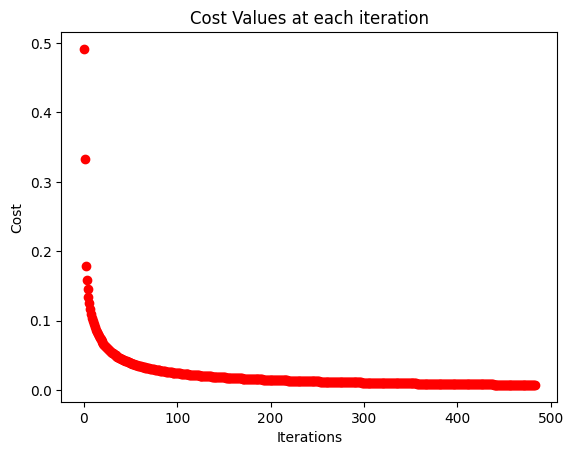

In [45]:
# define initial values for theta
rows, cols = X.shape
theta = np.array([1.0,1.0])

print("Theta is : " + str(theta))
a = 10
md = 0.01
# Run gradient descent
print("md is : " + str(md))
print("a is  : " + str(a))
thetas, c = gd(theta,md,a,X,Y,hLogistic,cost=cost_logistic)
print("t is  : " + str(thetas[-1]))

plt.plot(c, 'ro')
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.title("Cost Values at each iteration")
plt.show()

## Multivariate Logistic Regression
We can easily extend our method above to create a multivariate example with two features. In this case our data is idealized to show a linear decision boundary over two dimensions.

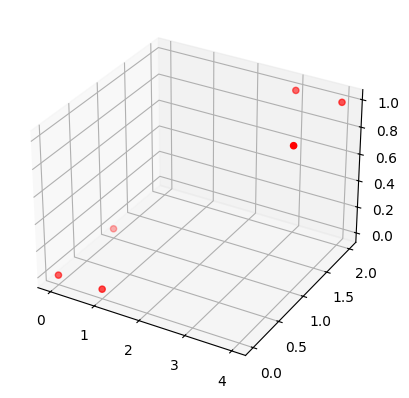

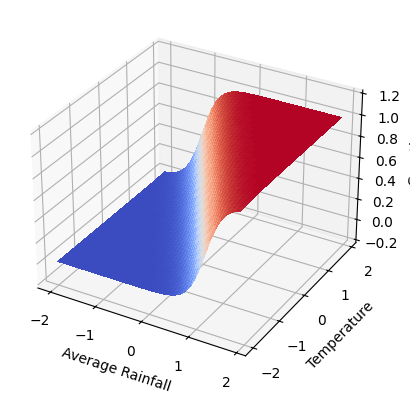

In [46]:
from mpl_toolkits.mplot3d import Axes3D

# Define the training data
Y = np.array([0,0,0,1,1,1])
X1 = np.array([0,1,0,4,3,4])
X2 = np.array([0,0,1,1,2,2])
X = np.vstack((X1,X2)).T

# Plot the training data in our usual way where the Target variable occupies the z-axis
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X1, X2, Y, c='r', marker='o')
plt.show()

# standardize our input features
X, means, stds = standardize(X)

# define initial values for theta
rows, cols = X.shape
theta = np.ones(1+cols)*1

# define the new matrix X based around our standardized vector for X previously obtained
x_0 = np.array([1]*rows)
X = np.hstack((x_0[:, np.newaxis],X))

# Perform Gradient Descent
thetas,c = gd(theta,md,a,X,Y,hLogistic)

# plot a surface based on the returned function parameters

# initialize values for features x1 and x2
x_range = np.arange(-2,2,0.1)

x1s, x2s = np.meshgrid(x_range, x_range) # remember - plt.surface likes this meshgrid output
mesh_rows, mesh_cols = x1s.shape

# construct 1D arrays for x1, x2 and x0
x1 = np.ravel(x1s)
x2 = np.ravel(x2s)
x0 = np.array([1]*len(x2))

# merge 1D arrays into a single x array for calculations",
x = np.matrix([x0,x1,x2])

# perform calculations",
z = hLogistic(thetas[-1,:],x)

# reshape result to have the same organization as result of meshgrid \n",
zs = np.reshape(z,(mesh_rows,mesh_cols))

# plot the surface along with our training data points
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
surf = ax.plot_surface(x1s, x2s, zs, rstride=1, cstride=1, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
surf = ax.scatter(X[:,2], X[:,1], Y, c='r', marker='o')
ax.set_xlabel('Average Rainfall')
ax.set_ylabel('Temperature')
ax.set_zlabel('Growth')
ax.set_zlim(-0.2, 1.2)
plt.show()

## Non-Linear Logistic Regression
As with Linear Regression we can extend the method to provide non-linear decision boundaries simply by introducing extra non-linear functions of our data.

For example, lets consider the case where positive examples are clustered together and negative examples form a ring around that cluster as illustrated below.

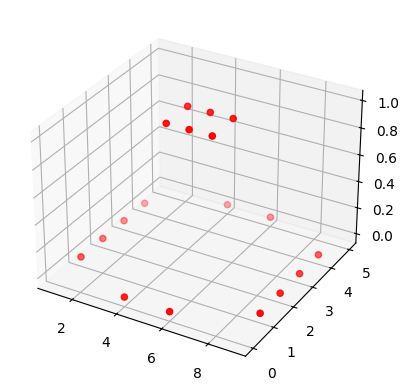

In [47]:
# Define the training data
Y = np.array([ 0,0,0,0,0,       1,1,1,  0,0,    1,1,1,     0,0,0,0,0])
X1 = np.array([4,6,1,9,1,       4,5,6,  9,1,    4,5,6,     9,1,9,4,6])
X2 = np.array([0,0,1,1,2,       2,2,2,  2,3,    3,3,3,     3,4,4,5,5])
X = np.vstack((X1,X2)).T

# Plot the training data in our usual way where the Target variable occupies the z-axis
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X1, X2, Y, c='r', marker='o')
plt.show()

Or with normalized data:

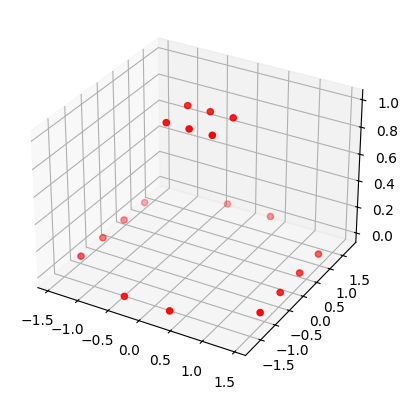

In [48]:
# standardize our input features
X, means, stds = standardize(X)

# Plot the training data in our usual way where the Target variable occupies the z-axis
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:,0], X[:,1], Y, c='r', marker='o')
plt.show()

If we attempt to model this data distribution directly we see that the results are poor. We have to define a max number of iterations as otherwise the gradient descent algorithm will fail to find a solution that is useful and will instead bounce backwards and forward around the parameter space.

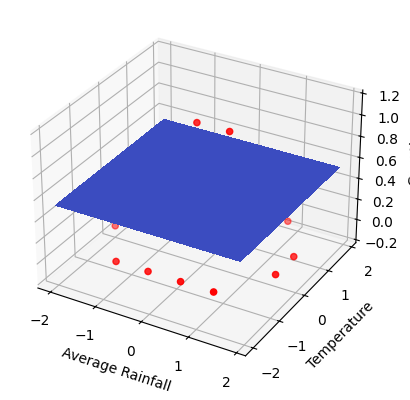

In [49]:
# define initial values for theta
rows, cols = X.shape
theta = np.ones(1+cols)*1

# define the new matrix X based around our standardized vector for X previously obtained
x_0 = np.array([1]*rows)
X = np.hstack((x_0[:, np.newaxis],X))

# Perform Gradient Descent
thetas,c = gd(theta,md,a,X,Y,hLogistic,maxiterations=1000)

# plot a surface based on the returned function parameters

# initialize values for features x1 and x2
x_range = np.arange(-2,2,0.1)

x1s, x2s = np.meshgrid(x_range, x_range) # remember - plt.surface likes this meshgrid output
mesh_rows, mesh_cols = x1s.shape

# construct 1D arrays for x1, x2 and x0
x1 = np.ravel(x1s)
x2 = np.ravel(x2s)
x0 = np.array([1]*len(x2))

# merge 1D arrays into a single x array for calculations",
x = np.matrix([x0,x1,x2])

# perform calculations",
z = hLogistic(thetas[-1,:],x)

# reshape result to have the same organization as result of meshgrid \n",
zs = np.reshape(z,(mesh_rows,mesh_cols))

# plot the surface along with our training data points
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
surf = ax.plot_surface(x1s, x2s, zs, rstride=1, cstride=1, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
surf = ax.scatter(X[:,2], X[:,1], Y, c='r', marker='o')
ax.set_xlabel('Average Rainfall')
ax.set_ylabel('Temperature')
ax.set_zlabel('Growth')
ax.set_zlim(-0.2, 1.2)
plt.show()

The surface when viewed in this way may give the impression that a separation has been achieved. However that is not in practice what is happening. Essentially the plane that has been returned is stating that for all locations the function s giving a roughly 50% probability that the value at that point will be a 1. This is not what we want. We want the function to closely match our data such that the function predicts 1 where we have positive cases and 0s where we have negative cases.

An circular decision boundary should give us a good approximation for this data. We would expect such a function to be of the form:

\begin{equation}
X^{2} + Y^{2} + aX + bY +c = 0
\end{equation}

We can achieve this by adding in two additional features which are squares of our original data.

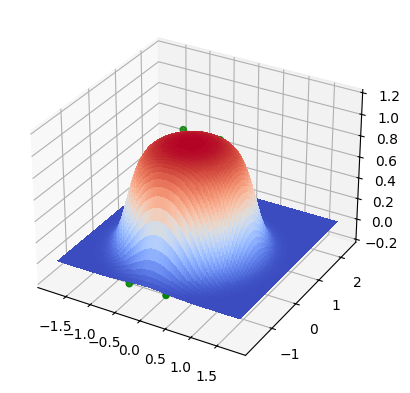

In [50]:
# Define the training data
Y = np.array([ 0,0,0,0,0,       1,1,1,  0,0,    1,1,1,     0,0,0,0,0])
X1 = np.array([4,6,1,9,1,       4,5,6,  9,1,    4,5,6,     9,1,9,4,6])
X2 = np.array([0,0,1,1,2,       2,2,2,  2,3,    3,3,3,     3,4,4,5,5])
X3 = X1**2
X4 = X2**2
X = np.vstack((X1,X2,X3,X4)).T

# standardize our input features
X, means, stds = standardize(X)

# define initial values for theta
rows, cols = X.shape
theta = np.ones(1+cols)*1

# define the new matrix X based around our standardized vector for X previously obtained
x_0 = np.array([1]*rows)
X = np.hstack((x_0[:, np.newaxis],X))

# Perform Gradient Descent
a = 5
thetas,c = gd(theta,md,a,X,Y,hLogistic,maxiterations=1000)

# plot a surface based on the returned function parameters

# initialize values for features x1 and x2
x_range = np.arange(0.,10.,0.1)
y_range = np.arange(0.,6.,0.1)

x1s, x2s = np.meshgrid(x_range, y_range) # remember - plt.surface likes this meshgrid output
mesh_rows, mesh_cols = x1s.shape

# construct 1D arrays for x1, x2 and x0
x1 = np.ravel(x1s)
x2 = np.ravel(x2s)
x3 = x1**2
x4 = x2**2
x = np.vstack((x1,x2,x3,x4)).T

# rescale our data based on our normalization parameters
x =  (x-means)/stds

# define the new matrix X based around our standardized vector for X previously obtained
x_0 = np.array([1]*len(x2))
x = np.hstack((x_0[:, np.newaxis],x))

# perform calculations
z = hLogistic(thetas[-1,:],x.T)

# reshape result to have the same organization as result of meshgrid
zs = np.reshape(z,(mesh_rows,mesh_cols))
x1s = np.reshape(x[:,1],(mesh_rows,mesh_cols))
x2s = np.reshape(x[:,2],(mesh_rows,mesh_cols))

# plot the surface along with our training data points
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
surf = ax.plot_surface(x1s, x2s, zs, rstride=1, cstride=1, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
surf = ax.scatter(X[:,1], X[:,2], Y, c='g', marker='o')
ax.set_zlim(-0.2, 1.2)
plt.show()

Rather than using up an axis dimension to explicitly visualize the Target variable as in the case above we can instead collapse this dimension and instead represent different classes with different icons. For example we can re-visualize our results below in 2D by plotting the points and the decision space as a contour plot.

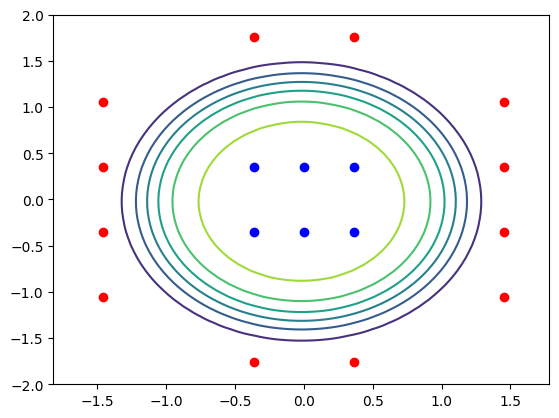

In [51]:
for l in range(len(Y)):
    if Y[l] == 0:
        plt.plot(X[l,1],X[l,2],'o',c='r')
    elif Y[l] == 1:
        plt.plot(X[l,1],X[l,2],'o',c='b')
    else: print(Y[l])

plt.contour(x1s, x2s, zs)
plt.ylim([-2,2])
plt.show()

Rather than printing the entire decision surface as a contour it is typically enough just to print the decision boundary, i.e., the line at which $P(Y=1)=0.5$.

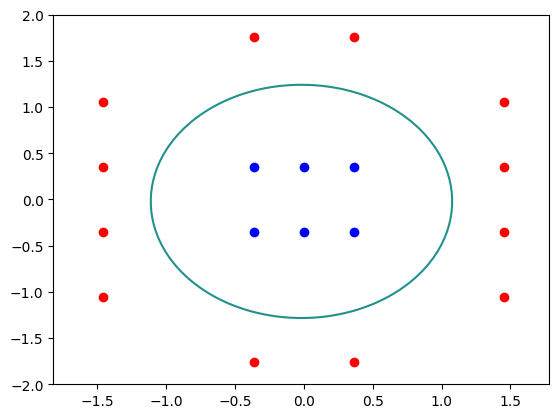

In [52]:
for l in range(len(Y)):
    if Y[l] == 0:
        plt.plot(X[l,1],X[l,2],'o',c='r')
    elif Y[l] == 1:
        plt.plot(X[l,1],X[l,2],'o',c='b')
    else: print(Y[l])

plt.contour(x1s, x2s, zs, 1)
plt.ylim([-2,2])
plt.show()

## Multinomial Logistic Regression
In the example to this point our Target Variable has been a single binary variable. In many practical examples we will instead have a target variable that is multinomial, e.g., 3 different colours, or 4 different disease types.

Logistic Regression cannot directly cope with more than two class types. However we can easily adopt our usage of Logistic Regression to handle more than two classes by applying **one hot encoding** to the target variable. **One Hot Encoding** is the rewriting of a single variable with greater than 2 classes into a number of individual binary variables where each binary variable indicates the presence of one of the original 3 classes.

To illustrate consider the multinomial target Y defined as a Python list alongside the two input features X1 and X2.

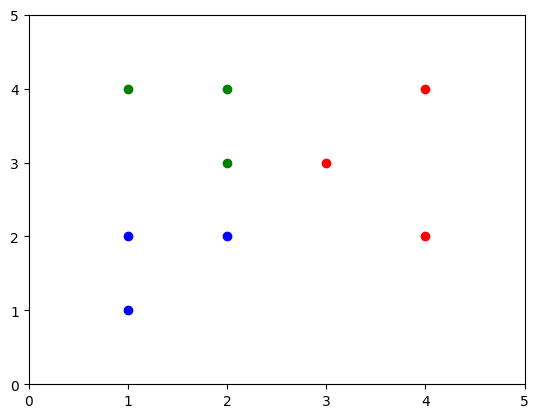

In [53]:
# Define the data - r for red, g for green, and b for blue
Y = ['b','b','r','b','g','r','g','r','g']
X1 = [1,1,4,2,2,3,1,4,2]
X2 = [1,2,4,2,3,3,4,2,4]

# Visualize as a multinomial problem
for i in range(len(Y)):
    plt.plot(X1[i],X2[i],'o',c=Y[i])
plt.ylim([0,5])
plt.xlim([0,5])
plt.show()

To recode this case we create 3 new target binary variables $Yr$, $Yg$, and $Yb$, where each variable captures where $Y$ was $r$, $g$, or $b$ respectively.

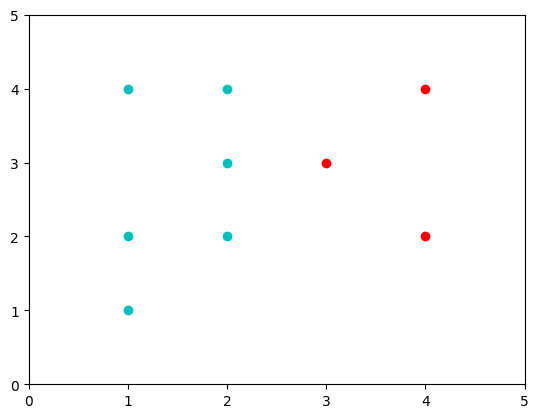

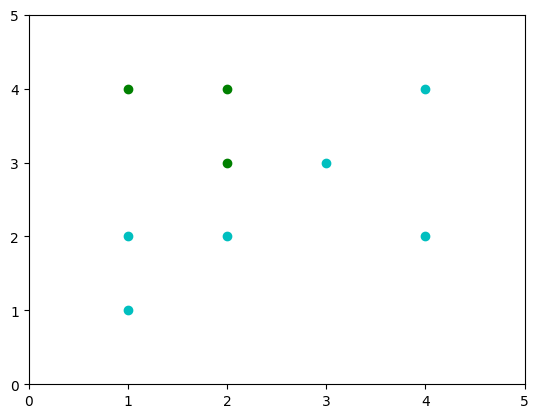

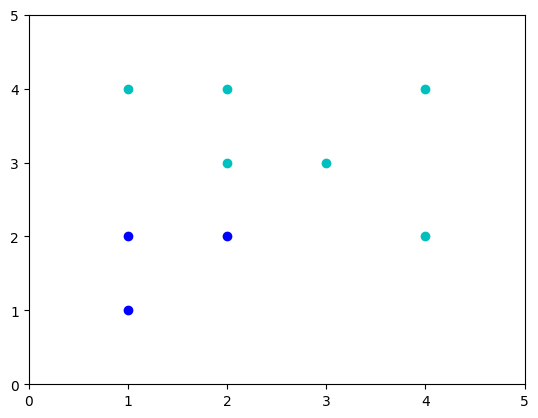

In [54]:
Yr = [1 if a =='r' else 0 for a in Y]
Yg = [1 if a =='g' else 0 for a in Y]
Yb = [1 if a =='b' else 0 for a in Y]

# Visualize as a 3 binary problem
for i in range(len(Yr)):
    if(Yr[i] == 1):
        plt.plot(X1[i],X2[i],'o',c='r')
    else:
        plt.plot(X1[i],X2[i],'o',c='c')
plt.ylim([0,5])
plt.xlim([0,5])
plt.show()

for i in range(len(Yg)):
    if(Yg[i] == 1):
        plt.plot(X1[i],X2[i],'o',c='g')
    else:
        plt.plot(X1[i],X2[i],'o',c='c')
plt.ylim([0,5])
plt.xlim([0,5])
plt.show()

for i in range(len(Yb)):
    if(Yb[i] == 1):
        plt.plot(X1[i],X2[i],'o',c='b')
    else:
        plt.plot(X1[i],X2[i],'o',c='c')
plt.ylim([0,5])
plt.xlim([0,5])
plt.show()

Rather than training one single model we end up training n distinct models - one for each of our new target variables. For a given model $i$ we are computing:

\begin{equation}
h_{\theta}^{(i)} (x) = P(y=i \;|\ x,\theta)
\end{equation}

i.e., the interpreted likelihood of the data $x$ resulting in the activation of the model with the specific parameters $\theta$. For a new data point we then simply want to produce the hypothesis for each trained model and select the maximum of these models:

\begin{equation}
\max_i h_{\theta}^{(i)}
\end{equation}


In [55]:
X = np.vstack((X1,X2)).T

# standardize our input features
X, means, stds = standardize(X)

# define initial values for theta
rows, cols = X.shape
theta = np.ones(1+cols)*1

# define the new matrix X based around our standardized vector for X previously obtained
x_0 = np.array([1]*rows)
X = np.hstack((x_0[:, np.newaxis],X))

# Perform Gradient Descent
a = 5
thetas_r,c_r = gd(theta,md,a,X,Yr,hLogistic,maxiterations=1000)
thetas_g,c_g = gd(theta,md,a,X,Yg,hLogistic,maxiterations=1000)
thetas_b,c_b = gd(theta,md,a,X,Yb,hLogistic,maxiterations=1000)

# Define some new data point
x_1 = [0,4]
x_2 = [0,3]

x = np.vstack((x_1,x_2)).T

# rescale our data based on our normalization parameters
x =  (x-means)/stds

# define the new matrix X based around our standardized vector for X previously obtained
x_0 = np.array([1]*len(x_2))
x = np.hstack((x_0[:, np.newaxis],x))

# perform calculations
z_r = hLogistic(thetas_r[-1,:],x.T)
print(z_r)

z_g = hLogistic(thetas_g[-1,:],x.T)
print(z_g)

z_b = hLogistic(thetas_b[-1,:],x.T)
print(z_b)


[2.32043769e-10 9.99996921e-01]
[2.93381016e-11 3.46136429e-09]
[1.0000000e+00 3.7122262e-09]


Therefore we can see that for multinomial logistic regression we need to train n different models for n different target labels. We will take a different approach in neural networks where we will train one single model with shared weights even in the case of a multinomial target.

## Logistic Regression the Easy Way
We can use scipy to perform Logistic Regression using the standard model interface.

In [56]:
from sklearn import linear_model

# Create the Logistic Regression model instance
logreg = linear_model.LogisticRegression(C=1e5)

# Fit the data
model = logreg.fit(X, Y)

print(model)

LogisticRegression(C=100000.0)


See SKLearn Logistic Regression 3-class Classifier for more detailed example.

## Lab Work

* Come up with your own classification task that has a clear binary distinction based on two input variables – you will need to use the multivariate code to work through this model.
* Can you come up with a pattern that is clearly a pattern, but which provides the training algorithm a little bit more challenge in coming up with a clear classification boundary?
* Using python on your own laptop, take my own code for the basic learn regression model and get it working as a simple python (.py) chunk of code rather than a jupyter notebook
